#**LAB №2 Preprocessing and Classification**
**Максимов Антон 17ПМИ**



1.   Предобработать собранный корпус (датасет новостей): удаление знаков препинания и лишних символов, токенизация, приведение к нормальной форме, удаление стоп-слов. Полезные библиотеки:
SpaCy: https://spacy.io Очень много функций, однако большинство из них реализовано только для английского языка
Natural Language Toolkit (NLTK): https://www.nltk.org Много поддерживаемых языков, широкий набор инструментов и решаемых задач, однако многие реализованные в этой библиотеке алгоритмы довольно простые, из-за чего точность будет далека от оптимальной
Морфологический анализатор pymorphy2 для русского языка: https://pymorphy2.readthedocs.io в частности, поддерживает приведение слов к нормальной форме
Yandex Mystem 3.1: https://github.com/nlpub/pymystem3
2.   Векторизовать тексты
3.   С помощью моделей классического машинного обучения выполнить классификацию категорий собственного новостного корпуса. Добиться как можно лучшего качества. Использовать минимум 6 методов (моделей)
4.   Выполнить анализ полученных результатов. Сравнить метрики качества, добавить необходимые визуализации, сделать выводы.



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/'My Drive'/DataScience/NLP

/content/gdrive/My Drive/DataScience/NLP


In [ ]:
!pip install pymystem3 stop_words pymorphy2 scikit-learn==0.24.1
import json
import requests
import pandas as pd
from multiprocessing.pool import ThreadPool
import nltk
import stop_words
import re
import string
import pymorphy2

##Prepairing corpus

In [ ]:
def save_json(articles):
  results = {}
  results['catalog'] = []
  for art in articles:
    results['catalog'].append(art)
  with open('corpus.json', 'w') as json_file:
    json.dump(results, json_file)
  print("Done!")

In [ ]:
categories = ['economics', 'forces', 'science', 'sport', 'culture', 'media']
articles = []
for c in categories:
  articles+=json.loads(open(c+'.json').read())['catalog']
save_json(articles)

Done!


##Preprocessing

* удаление знаков препинания и лишних символов
* токенизация
* приведение к нормальной форме
* удаление стоп-слов

In [124]:
corpus = json.loads(open('corpus.json').read())['catalog']

In [5]:
corpus[0]

{'article_id': 'https://lenta.ru/news/2020/06/22/enlarge/',
 'category': 'economics',
 'tags': ['Константин Юрченко', 'URA.RU.'],
 'text': 'Экономист Константин Юрченко перечислил способы, которые помогут накопить на безбедную старость. Об этом он рассказал порталу URA.RU.По его словам, россиянам стоит рассмотреть варианты с негосударственными пенсионными фондами (НПФ) и банковскими вкладами. При этом Юрченко отметил, что они обладают относительно невысокой доходностью.Также экономист посоветовал обратить внимание на рынок ценных бумаг. Однако, предупредил он, чтобы добиться успехов в этой сфере, необходимо научиться разбираться в работе финансовых инструментов.Еще одним способом получить дополнительный доход к пенсии Юрченко назвал вложения в недвижимость, которую впоследствии можно будет сдать в аренду. Но и в этом варианте имеются свои минусы, среди которых высокие цены, а также риск повышения налога на имущество.«Беда нашей экономики в том, что мы не можем устойчиво прогнозировать 

In [125]:
df = pd.DataFrame.from_dict(corpus).dropna(subset=['text'])
print(len(df))
df.tail()

20359


,article_id,title,category,tags,text
21156,https://lenta.ru/news/2020/12/20/myasnikov_cof...,Доктор Мясников развеял главные мифы о кофе,media,[Александр Мясников],Врач и телеведущий Александр Мясников развеял ...
21157,https://lenta.ru/news/2020/12/20/sobchakforrog...,Собчак переделала и спела песню «Иванушек» для...,media,"[Ксения Собчак, госкорпорации «Роскосмос», Дми...",Российская телеведущая Ксения Собчак посвятила...
21158,https://lenta.ru/news/2020/12/20/voina_vakcin/,Доктор Мясников сравнил российскую и американс...,media,"[Александр Мясников, Энтони Фаучи, Pfizer]",Врач и телеведущий Александр Мясников сравнил ...
21159,https://lenta.ru/news/2020/12/20/pornoactrisa/,Российская порноактриса раскрыла сложности раб...,media,None,"Российская порноактриса, работающая под псевдо..."
21160,https://lenta.ru/news/2020/12/20/ne_lozh/,Обвиненная во лжи Путину журналистка объяснилась,media,"[Владимиру Соловьеву, Владимиру Путину, Игорь ...",Директор издания «МК в Рязани» Александра Безу...


###Удаление знаков препинания и лишних символов

In [126]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0'])
regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
regex_dig = re.compile('[%s]' % re.escape(string.digits))
regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
regex_struct = re.compile('[%s]' % string.printable + string.whitespace)
emoji_pattern = re.compile("["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+")

In [250]:
def remove_extra_symbols(text):
  text = text.lower()
  text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', u'', text) #удаление ссылок
  text = re.sub(r"(\w)(\s)", r"\1 \2", text) #отделение слипшихся с пробельными символами

  #puncts = string.punctuation.replace('-', "")     #ПЫТАЛСЯ ОСТАВИТЬ СЛОВА ЧЕРЕЗ ДЕФИС, РАБОТАЕТ, НО НЕ ОЧЕНЬ ХОРОШО
  #text = re.sub(f'[{re.escape(puncts)}]', ' ', text) #если будете пробовать, это все расскомментить
  #text = re.sub(r'(?!\w+)[-]\d+|(?!\w+)', '', text)
  text = regex_punct.sub(' ', text)                   #эту закомментить

  text = regex_dig.sub(' ', text)
  text = regex_symb.sub(' ', text)
  text = regex_struct.sub(' ', text)
  text = emoji_pattern.sub(' ', text)
  #text = re.sub(r'\s+', ' ', text)
  text = re.sub(' +' , ' ', text) #удаление лишних пробелов
  return text


In [241]:
corpus[3]['text']

'Россия согласилась провести встречу в формате ОПЕК+ по сокращению добычи нефти на несколько дней раньше — не 9-10 июня, а 4-го. Об этом сообщили сразу три источника в организации, передает Reuters.Предложение о переносе переговоров поступило от Алжира. Предполагалось, что на ней стороны обсудят новые условия сделки, ужесточающие ограничения во второй половине года.В России идея обсуждалась на совещании у министра энергетики с участием глав нефтяных компаний. По его итогам СМИ стало известно, что мнения разделились поровну, а окончательное решение не принято. Поддержка переноса даты заседания может означать, что Москва определилась с позицией по этому поводу и готова к пересмотру.В настоящее время и до июля условия сделки предусматривают сокращение добычи на 9,7 миллиона баррелей в сутки, а затем, до 2021 года, оно должно было составить 7,7 миллиона. Однако Саудовская Аравия, недовольная скоростью восстановления цен, предложила обсудить продление ограничений на 9,7 миллиона баррелей до

In [249]:
remove_extra_symbols(corpus[3]['text'])

'судостроительный комплекс звезда приступил к строительству головного атомного ледокола проекта лидер в блоке корпусных производств судоверфи состоялась резка первых деталей корпуса для будущего судна флагманскому ледоколу присвоено имя россия об этом ленте ру сообщили в пресс-службе компании роснефть судно станет самым мощным атомоходом в истории мирового судостроения этот сложнейший с технической точки зрения проект не имеет аналогов в мире подчеркнули в пресс-службе компании его ключевая задача обеспечить круглогодичную проводку коммерческого флота по северному морскому пути проект лидер станет основой российского ледокольного флота нового поколения длина нового атомохода составит метров ширина метров осадка метров ледокол россия будет оснащен двумя атомными реакторами типа ритм четырьмя турбинами и четырьмя гребными электродвигателями суммарная мощность энергоустановок ледокола составит мегаватт что позволит судну преодолевать льды толщиной более метров со скоростью узла при толщин

###Токенизация, Приведение к нормальной форме и Удаление стоп-слов

In [140]:
morph=pymorphy2.MorphAnalyzer()
def tokenize_and_normalize_sw(text):
    sw = stop_words.get_stop_words('russian')
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for token in tokens:
        formword = morph.parse(token)
        if
        words.append(formword[0].normal_form)
    cleaned_words = [word for word in words if word not in sw]
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_words, cleaned_text

In [141]:
tokenize_and_normalize_sw(remove_extra_symbols(corpus[0]['text']))[1]

'экономист константин юрченко перечислить способ помочь накопить безбедный старость рассказать портал ura ru слово россиянин стоить рассмотреть вариант негосударственный пенсионный фонд нпф банковский вклад юрченко отметить обладать относительно невысокий доходность экономист посоветовать обратить внимание рынок ценный бумага предупредить добиться успех сфера необходимо научиться разбираться работа финансовый инструмент способ получить дополнительный доход пенсия юрченко назвать вложение недвижимость впоследствии сдать аренда вариант иметься свой минус среди высокий цена риск повышение налог имущество беда экономика устойчивый прогнозировать длинный временной интервал поэтому выбор любой финансовый инструмент своеобразный рулетка вариант риск резюмировать'

In [142]:
import time
from tqdm.notebook import tqdm
tqdm.pandas()

In [171]:
df = pd.DataFrame.from_dict(corpus).dropna(subset=['text'])

In [172]:
sw = stop_words.get_stop_words('russian')
df['filtered_words'] = df.progress_apply(lambda x: tokenize_and_normalize_sw(remove_extra_symbols(x['text']))[0], axis=1)
df['filtered_text'] = df.progress_apply(lambda x: ' '.join(x['filtered_words']), axis = 1)

In [ ]:
df.to_csv('preprocessed.csv', index=False)

##Text Vectorization

In [253]:
df.head()

,article_id,title,category,tags,text,filtered_words,filtered_text
0,https://lenta.ru/news/2020/06/22/enlarge/,Названы способы накопить на безбедную старость,economics,"[Константин Юрченко, URA.RU.]",Экономист Константин Юрченко перечислил способ...,"[экономист, константин, юрченко, перечислить, ...",экономист константин юрченко перечислить спосо...
1,https://lenta.ru/news/2020/06/08/oil/,Цены на нефть подскочили,economics,[правительство России],Цены на нефть подскочили до максимумов с начал...,"[цена, нефть, подскочить, максимум, начало, ма...",цена нефть подскочить максимум начало март сви...
2,https://lenta.ru/news/2020/06/29/finansirovanie/,Минфин сократит финансирование нацпроектов,economics,[Министерство финансов России],Министерство финансов России намерено сократит...,"[министерство, финансы, россия, намерить, сокр...",министерство финансы россия намерить сократить...
3,https://lenta.ru/news/2020/07/06/zvzd/,На судоверфи «Звезда» стали строить самый мощн...,economics,"[компанией «Роснефть», госкорпорация «Росатом»...",Судостроительный комплекс «Звезда» приступил к...,"[судостроительный, комплекс, звезда, приступит...",судостроительный комплекс звезда приступить ст...
4,https://lenta.ru/news/2020/07/20/perevod/,Россиянам сделали скидку 90 процентов при пере...,economics,"[Михаил Мишустин, «Газпром»]",Перевод машин с бензина на газ стал на 90 проц...,"[перевод, машина, бензин, газ, стать, процент,...",перевод машина бензин газ стать процент дешёвы...


In [4]:
df = pd.read_csv('preprocessed.csv')  

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MultiLabelBinarizer

In [26]:
sorted(['economics', 'forces', 'science', 'sport', 'culture', 'media'])

['culture', 'economics', 'forces', 'media', 'science', 'sport']

In [85]:
X = df['filtered_text']
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

vectorizer=TfidfVectorizer(min_df=5, max_df=0.4)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

##Text Classification

In [90]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix,confusion_matrix
import sklearn.metrics as metrics
import seaborn as sns

In [128]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc


In [93]:
def print_evaluation_scores(y_test, predicted):    
    print("Accuracy Score :" ,accuracy_score(y_test, predicted))
    print("F1 Score :" ,f1_score(y_test, predicted, average='weighted'))

In [170]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, y_arg=None, figsize=(17, 6)):
    if y_arg is not None:
       y_score = y_arg
    else:
       y_score = clf.decision_function(X_test)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

###**LinearSVC**

In [172]:
model = LinearSVC().fit(X_train_tfidf.toarray(), y_train)
y_predicted_labels = model.predict(X_test_tfidf.toarray())
y_scores = model.decision_function(X_test_tfidf.toarray())
print_evaluation_scores(y_test, y_predicted_labels)

Accuracy Score : 0.9614440078585462
F1 Score : 0.9613033039156547


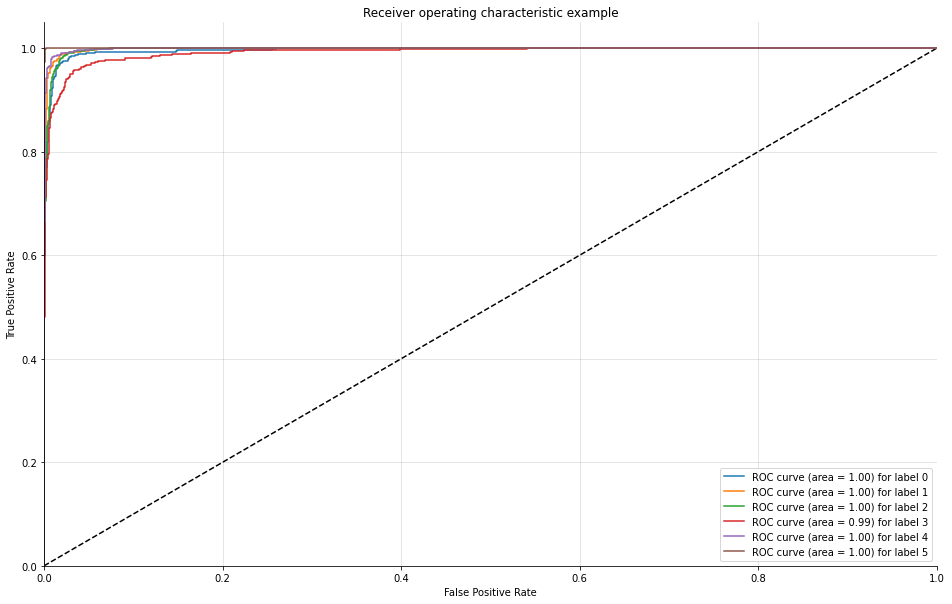

In [173]:
plot_multiclass_roc(model, X_test_tfidf.toarray(), y_test, n_classes=6, figsize=(16, 10))

**Roc-кривые приближены к верхнему левому краю - это хорошо**

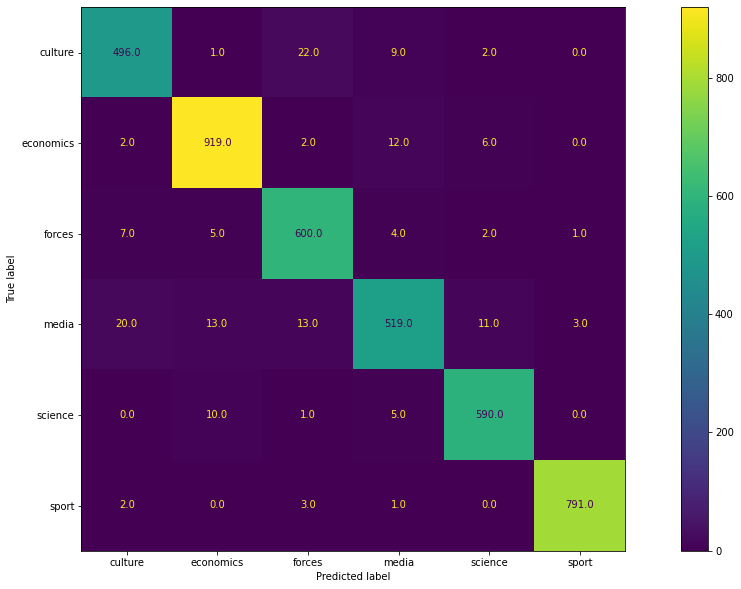

In [106]:
plot_confusion_matrix(model,X_test_tfidf.toarray(),y_test,values_format='0.1f')  
plt.gcf().set_size_inches(20,10)
plt.show()

**Чаще всего ошибочно определяются: медиа как культура, новости силовых структур как культура**  

###**LogisticRegression**

In [115]:
model = LogisticRegression().fit(X_train_tfidf.toarray(), y_train)
y_predicted_labels = model.predict(X_test_tfidf.toarray())
y_scores = model.decision_function(X_test_tfidf.toarray())
print_evaluation_scores(y_test, y_predicted_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy Score : 0.9521119842829077
F1 Score : 0.9519746025240348


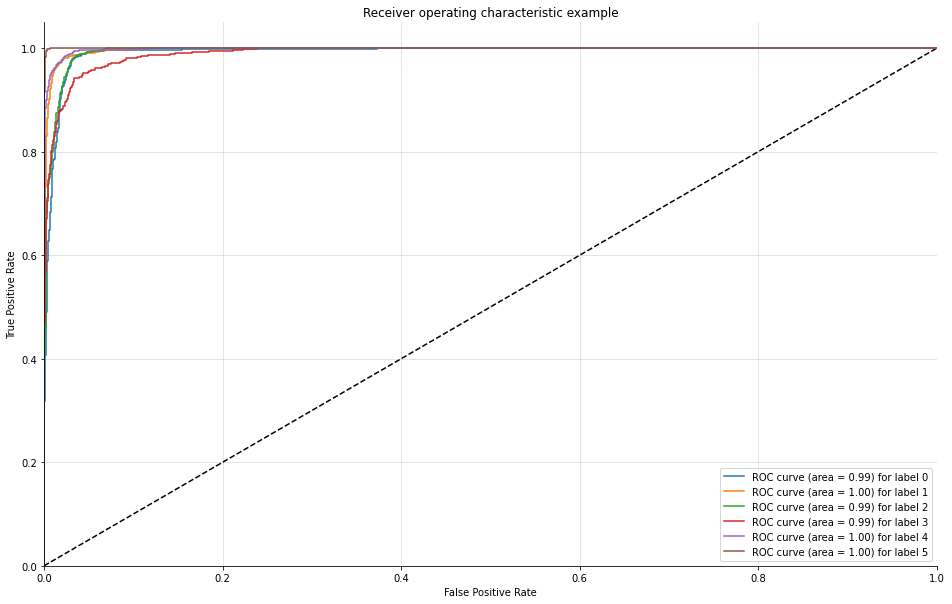

In [116]:
plot_multiclass_roc(model, X_test_tfidf.toarray(), y_test, n_classes=6, figsize=(16, 10))

Аналогично, точность классификаторов хорошая, видимо из-за объемного датасета

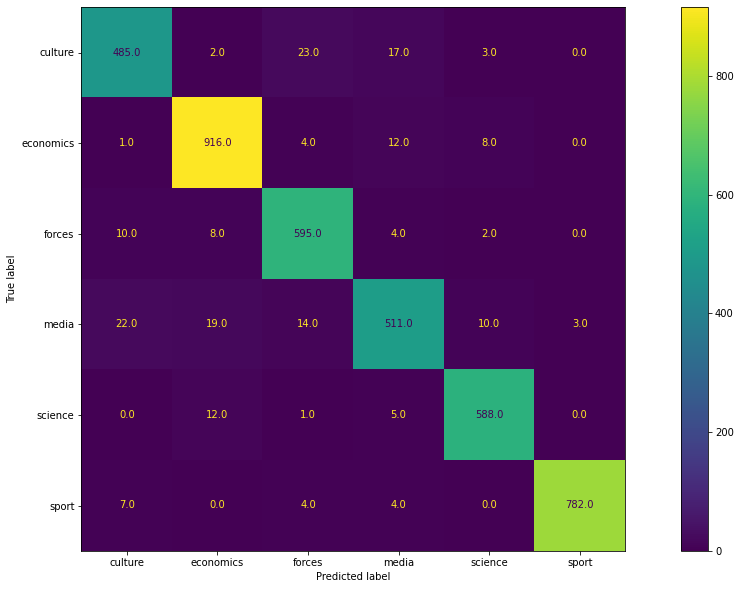

In [117]:
plot_confusion_matrix(model,X_test_tfidf.toarray(),y_test,values_format='0.1f')  
plt.gcf().set_size_inches(20,10)
plt.show()

###**KNeighborsClassifier**

In [138]:
model = KNeighborsClassifier(n_neighbors=3).fit(X_train_tfidf.toarray(), y_train)
y_predicted_labels = model.predict(X_test_tfidf.toarray())
y_scores = model.predict_proba(X_test_tfidf.toarray())
print_evaluation_scores(y_test, y_predicted_labels)

Accuracy Score : 0.9169941060903732
F1 Score : 0.9165457003263797


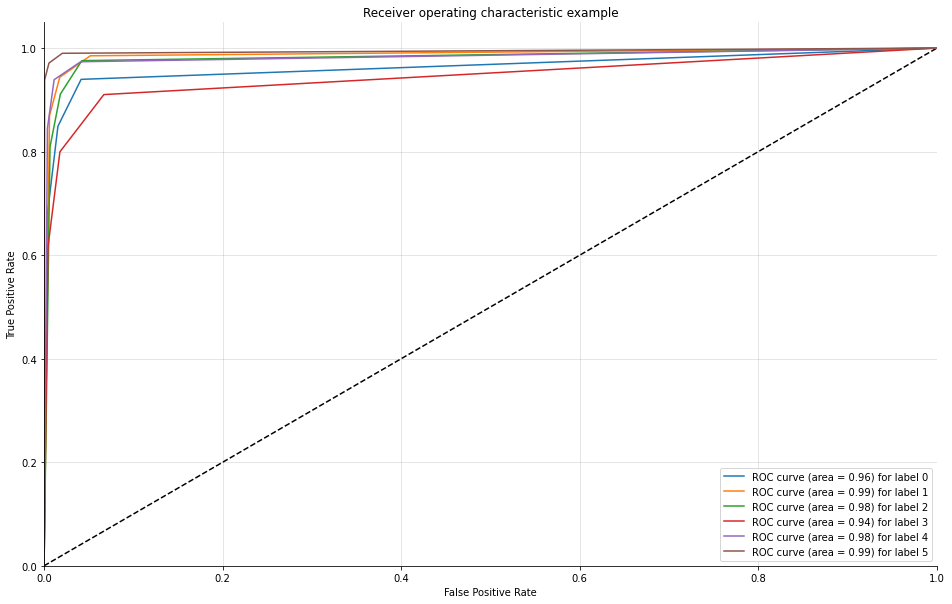

In [140]:
plot_multiclass_roc(model, X_test_tfidf.toarray(), y_test, n_classes=6, y_arg=y_scores, figsize=(16, 10))

**Здесь сильно отличается график от всех остальных, как и точность, возможно из небольшого количества соседей**

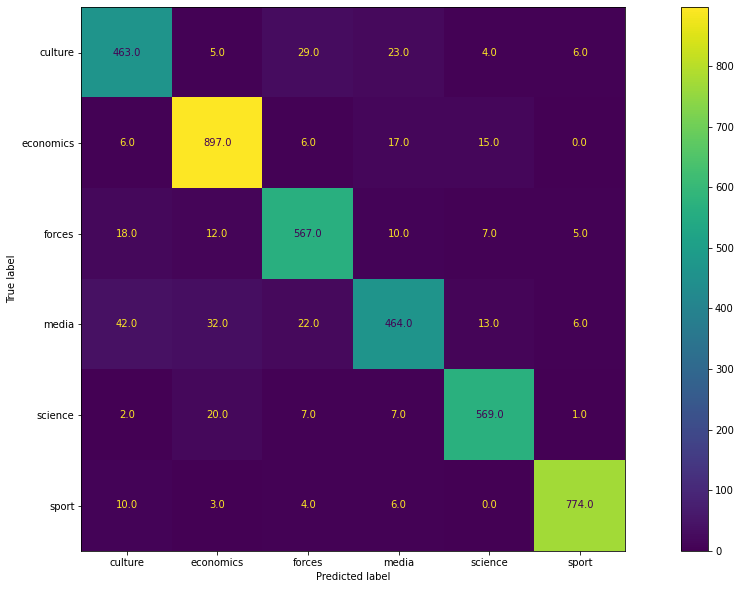

In [141]:
plot_confusion_matrix(model,X_test_tfidf.toarray(),y_test,values_format='0.1f')  
plt.gcf().set_size_inches(20,10)
plt.show()

###**MultinomialNB**

In [159]:
model = MultinomialNB(alpha=.01).fit(X_train_tfidf.toarray(), y_train)
y_predicted_labels = model.predict(X_test_tfidf.toarray())
y_scores = model.predict_proba(X_test_tfidf.toarray())
print_evaluation_scores(y_test, y_predicted_labels)

Accuracy Score : 0.93786836935167
F1 Score : 0.937740362906774


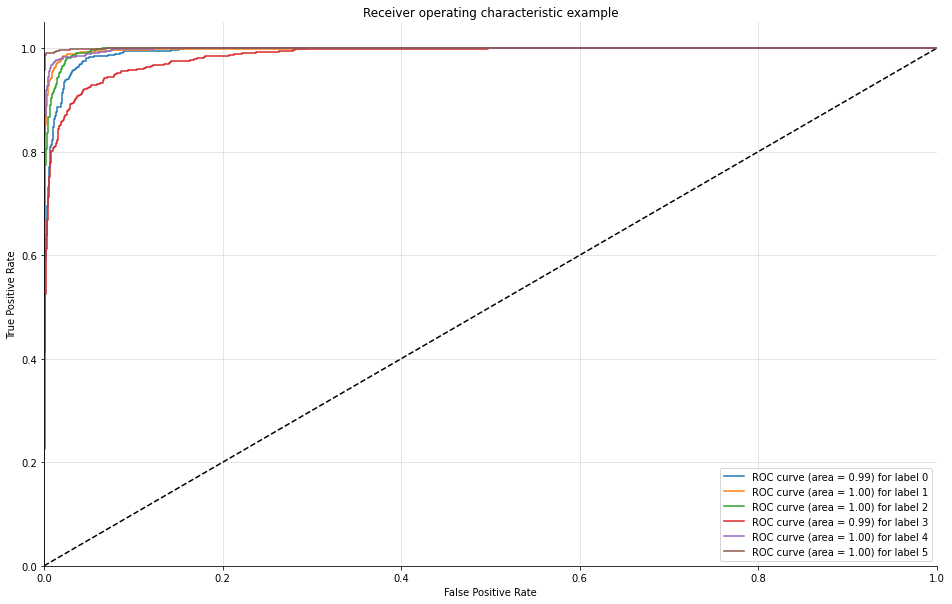

In [171]:
plot_multiclass_roc(model,X_test_tfidf.toarray(), y_test, n_classes=6, y_arg=y_scores, figsize=(16, 10))

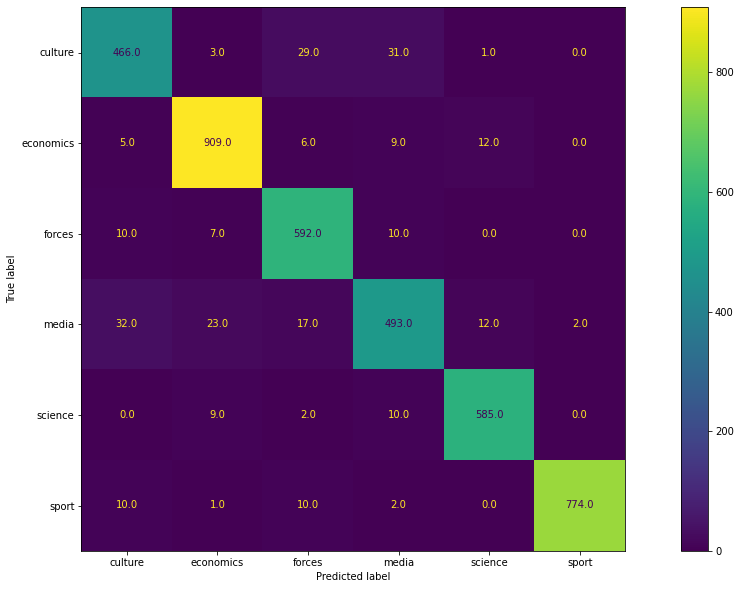

In [126]:
plot_confusion_matrix(model,X_test_tfidf.toarray(),y_test,values_format='0.1f')  
plt.gcf().set_size_inches(20,10)
plt.show()

**Снова культура определяется как медиа и наоборот**

###**BernoulliNB**

In [142]:
model = BernoulliNB(alpha=.005).fit(X_train_tfidf.toarray(), y_train)
y_predicted_labels = model.predict(X_test_tfidf.toarray())
y_scores = model.predict_proba(X_test_tfidf.toarray())
print_evaluation_scores(y_test, y_predicted_labels)

Accuracy Score : 0.9300098231827112
F1 Score : 0.9299810914911003


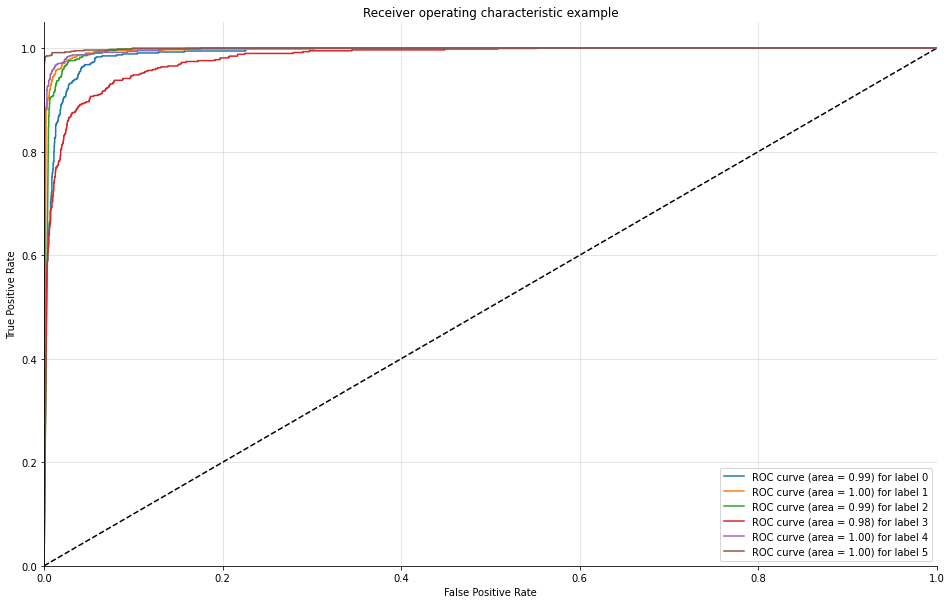

In [143]:
plot_multiclass(model,X_test_tfidf.toarray(), y_test, n_classes=6, y_score=y_scores, figsize=(16, 10))

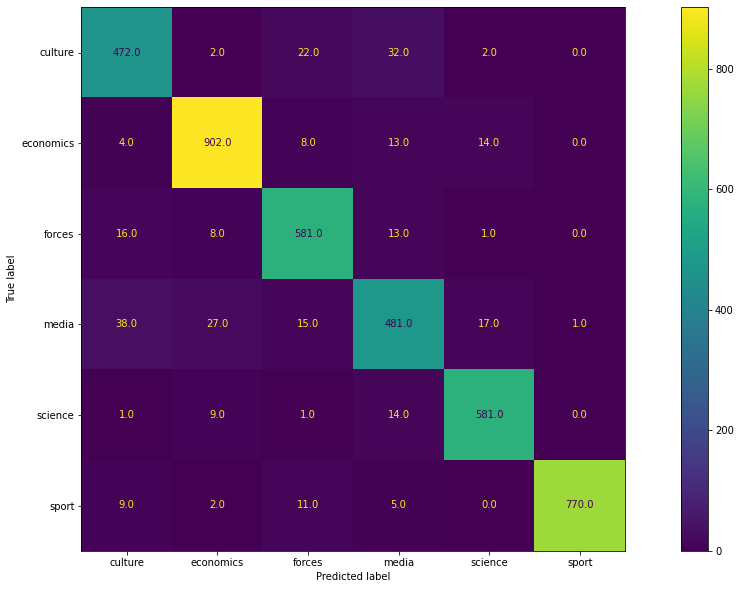

In [144]:
plot_confusion_matrix(model,X_test_tfidf.toarray(),y_test,values_format='0.1f')  
plt.gcf().set_size_inches(20,10)
plt.show()

**Аналогично**

###**RandomForestClassifier**

In [175]:
model = RandomForestClassifier().fit(X_train_tfidf.toarray(), y_train)
y_predicted_labels = model.predict(X_test_tfidf.toarray())
y_scores = model.predict_proba(X_test_tfidf.toarray())
print_evaluation_scores(y_test, y_predicted_labels)

Accuracy Score : 0.9339390962671905
F1 Score : 0.9332879591545824


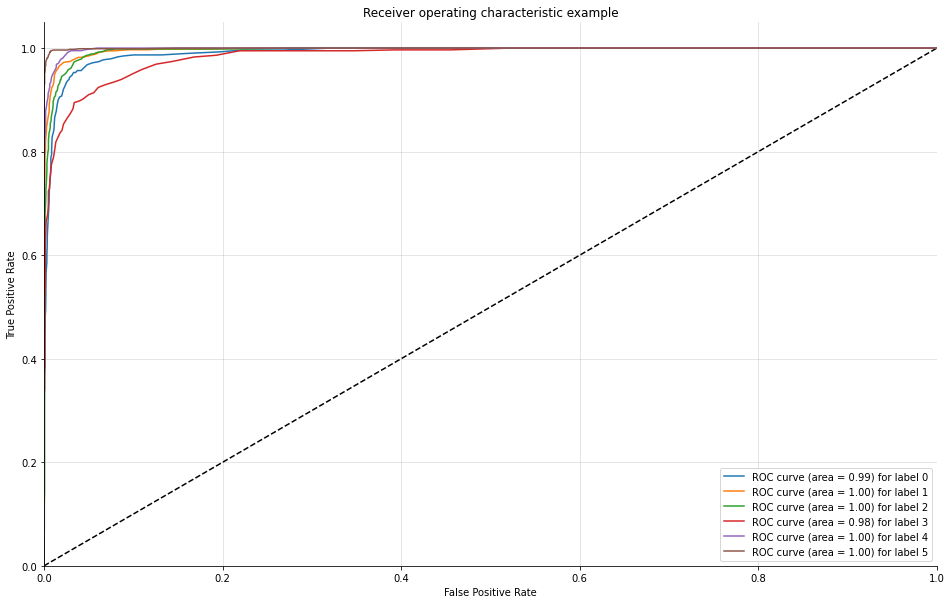

In [176]:
plot_multiclass_roc(model, X_test_tfidf.toarray(), y_test, n_classes=6, y_arg=y_scores, figsize=(16, 10))

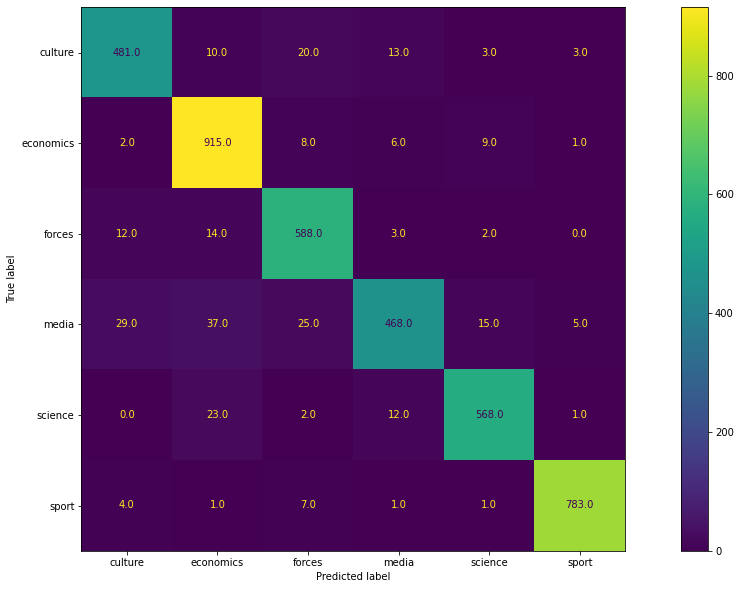

In [177]:
plot_confusion_matrix(model,X_test_tfidf.toarray(),y_test,values_format='0.1f')  
plt.gcf().set_size_inches(20,10)
plt.show()

##Analysis of results

**Вывод: Чаще всего путаются медиа и культура (и наоборот), точность всех классификаторов довольна большая, возможно это связано с большим датасетом. Также можно было улучшить, используя слова с дефисами на препроцессинге, но РЕГУЛЯРКИ - не могу больше на них смотреть.**